### Homework 3 (DBSCAN)

- Gets data from `Econom_cities_data`
- Use `plot` function from official [sklearn documentation](https://scikit-learn.org/stable/auto_examples/cluster/plot_hdbscan.html#sphx-glr-auto-examples-cluster-plot-hdbscan-py).

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

import warnings
warnings.filterwarnings('ignore')

matplotlib.style.use('ggplot')

In [2]:
def plot(X, labels, probabilities=None, parameters=None, ground_truth=False, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 4))
    labels = labels if labels is not None else np.ones(X.shape[0])
    probabilities = probabilities if probabilities is not None else np.ones(X.shape[0])
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    # The probability of a point belonging to its labeled cluster determines
    # the size of its marker
    proba_map = {idx: probabilities[idx] for idx in range(len(labels))}
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_index = (labels == k).nonzero()[0]
        for ci in class_index:
            ax.plot(
                X[ci, 0],
                X[ci, 1],
                "x" if k == -1 else "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=4 if k == -1 else 1 + 5 * proba_map[ci],
            )
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    preamble = "True" if ground_truth else "Estimated"
    title = f"k={n_clusters_}"
    if parameters is not None:
        parameters_str = ", ".join(f"{k}={v}" for k, v in parameters.items())
        title += f", {parameters_str}"
    ax.set_title(title)

---

Очищаю данные и стандартизирую их аналогично `hw01`

In [3]:
df = pd.read_csv('../data/Econom_Cities_data.csv', sep = ';', decimal=',',  index_col='City')

df_clean = df.drop(['Jakarta', 'Cairo'], axis=0)

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(df_clean), index=df_clean.index, columns=df_clean.columns)

**Для кластеризации использую метод DBSCAN**

У метода есть слабое место: сильная зависимость от гиперпараметров. Я проведу подбор параметров `eps` и `min_samples` методом поиска по сетке.

На графиках ниже изображены результаты кластеризации для различных комбинаций гиперпараметров (функцию отрисовки взял из официальной документации sklearn).

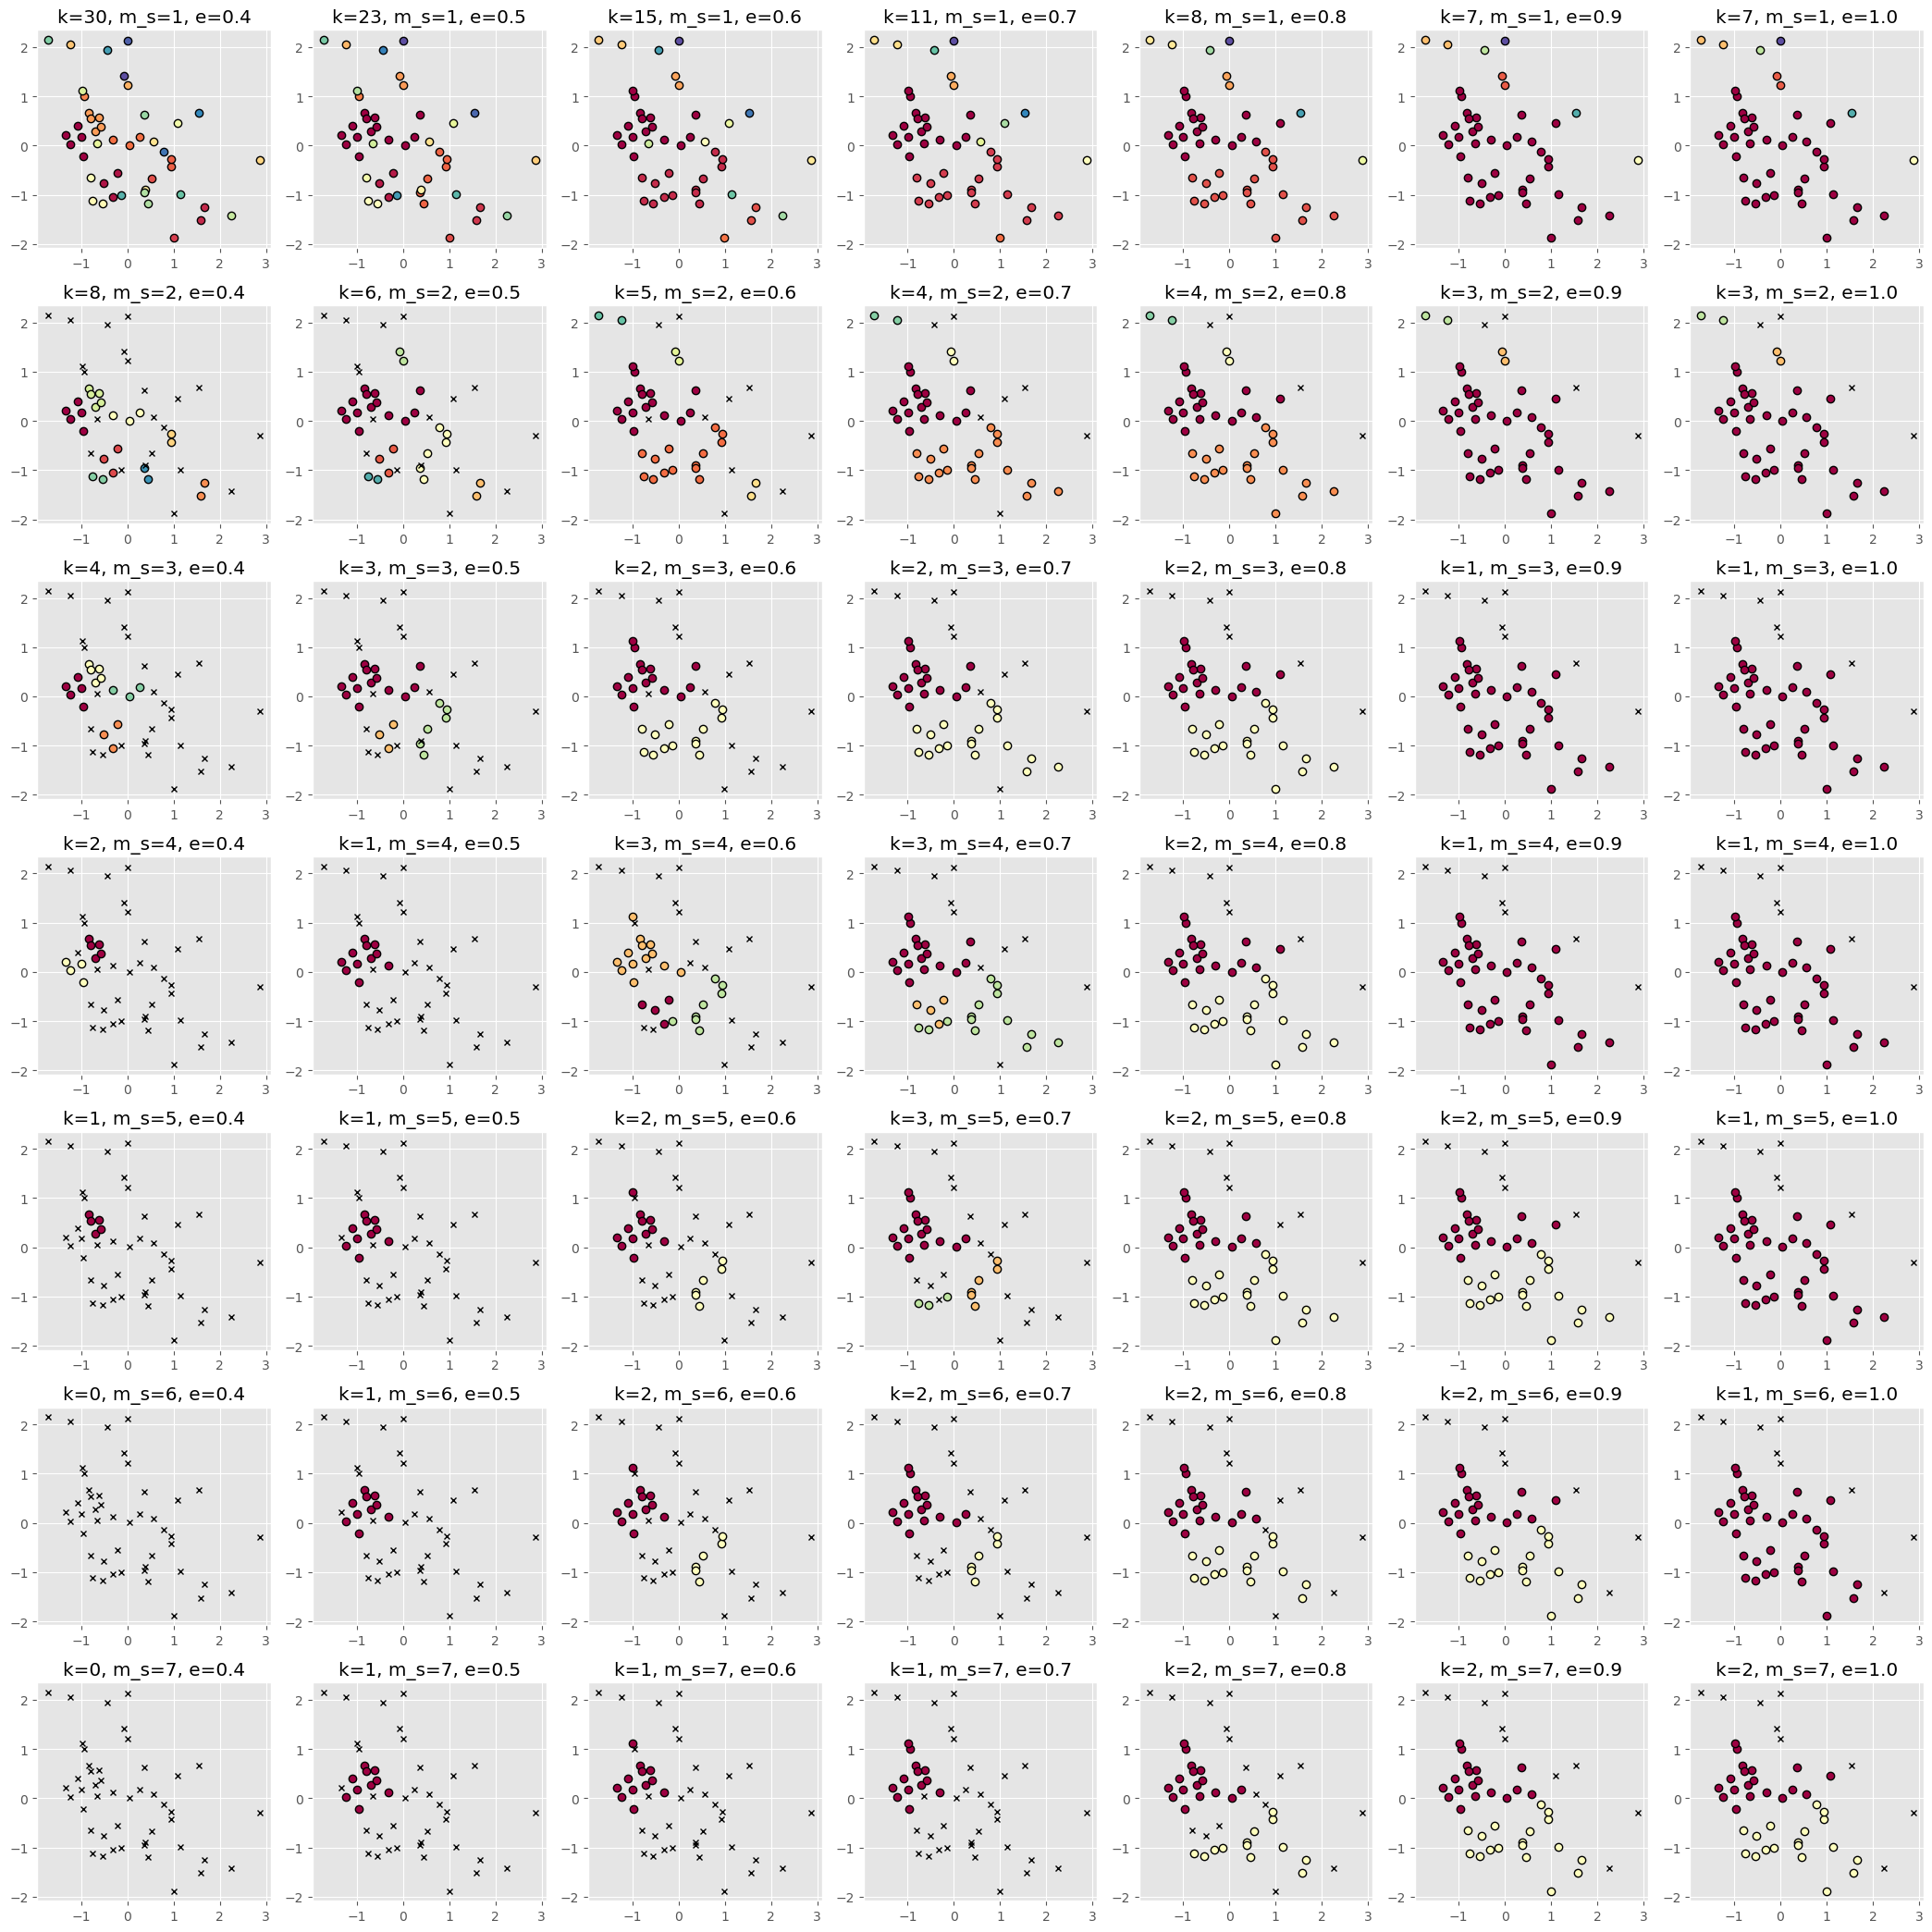

In [ ]:
epses = np.round(np.arange(0.4, 1.1, 0.1), 1)
min_samples = np.arange(1, 8, 1)
grid = np.array(np.meshgrid(epses, min_samples)).T.reshape(-1,2)

n_rows, n_cols = min_samples.shape[0], epses.shape[0]

dbs_labels_freq = []
dbs_none_count = []

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_rows * 3, n_cols * 3))
for i, (eps, min_sample) in enumerate(grid):
    dbs = DBSCAN(eps=eps, min_samples=int(min_sample))
    dbs.fit(X)
    id_x, id_y = i // n_rows, i % n_rows

    if id_y < axes.shape[0] and id_x < axes.shape[1]:
        plot(X.to_numpy(), dbs.labels_, parameters={"m_s": int(min_sample), "e": eps}, ax=axes[id_y][id_x])
    
    labels_freq = np.unique(dbs.labels_, return_counts=True)
    dbs_none_count.append(labels_freq[1][0])
    dbs_labels_freq.append(np.asarray(labels_freq).T)

plt.show()

Чтобы не скатываться в эвристику и субъективность слишком далеко, определим *оптимальные* гиперпараметры по количеству *выбросов* - объектов из класса `-1`. 

In [ ]:
top5 = np.argsort(dbs_none_count)[:5]

print("\n Params of top-5:")
print(grid[top5])

print("\n Labels of top-5:")
for i in top5:
    print("-" * 5)
    print(dbs_labels_freq[i])


 Params of top-5:
[[1.  2. ]
 [0.9 2. ]
 [0.8 2. ]
 [0.4 1. ]
 [0.7 2. ]]

 Labels of top-5:
-----
[[-1  4]
 [ 0 38]
 [ 1  2]
 [ 2  2]]
-----
[[-1  4]
 [ 0 38]
 [ 1  2]
 [ 2  2]]
-----
[[-1  4]
 [ 0 19]
 [ 1 19]
 [ 2  2]
 [ 3  2]]
-----
[[ 0  5]
 [ 1  3]
 [ 2  2]
 [ 3  1]
 [ 4  1]
 [ 5  2]
 [ 6  3]
 [ 7  1]
 [ 8  5]
 [ 9  1]
 [10  1]
 [11  1]
 [12  1]
 [13  1]
 [14  2]
 [15  1]
 [16  1]
 [17  1]
 [18  1]
 [19  1]
 [20  2]
 [21  1]
 [22  1]
 [23  1]
 [24  1]
 [25  1]
 [26  1]
 [27  1]
 [28  1]
 [29  1]]
-----
[[-1  7]
 [ 0 17]
 [ 1 18]
 [ 2  2]
 [ 3  2]]


Из данного топ-5 я выбрал параметры `eps=0.8` и `min_samples=2`, так как:
- **минимальное** количество выбросов
- нет **переобучения** -- слишком большого количества кластеров
- данные **достаточно** разбиты на отдельные кластеры

Видим неравномерность в разбиении кластеров, но это может быть следствием недостаточным объёмом исходной выборки (присутствует несбалансированность).

Теперь проанализируем полученные кластеры после DBSCAN

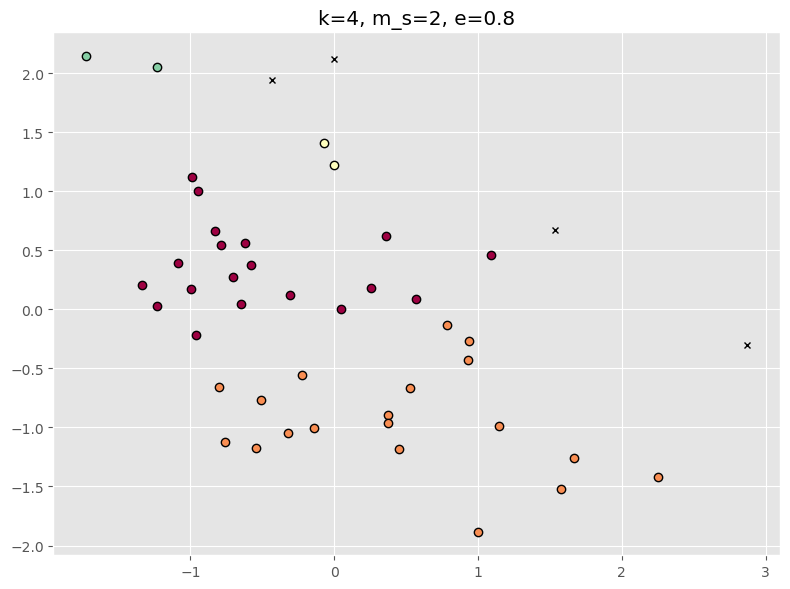

In [77]:
dbs = DBSCAN(eps=0.8, min_samples=2)
dbs.fit(X)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plot(X.to_numpy(), dbs.labels_, parameters={"m_s": 2, "e": 0.8}, ax=ax)
plt.show()


In [78]:
df_clean['cluster'] = dbs.labels_

df_clean.groupby('cluster').mean()

,Work,Price,Salary
cluster,,,
-1,2051.250000,93.600000,42.375000
0,1792.000000,77.526316,55.157895
1,1959.210526,50.115789,14.789474
2,1874.000000,97.950000,95.150000
3,1625.000000,114.550000,65.150000


- **0** - *средние* города: количество часов, индекс цен и зарплаты находятся в *балансе*

- **1** - самые плохо оплачиваемые города: много часов за маленькую плату

- **2** - самые *работающие* города: много часов за большие деньги, при небольших ценах

- **3** - в этих городах работают меньше всего, при этом самые большие цены, что компенсируется увеличенными зарплатами

Остальные города формируют отдельный кластер `-1`: данные для этих городов являются характерными сразу для нескольких кластеров, поэтому их трудно отнести к одному из них. Это можно увидеть ниже.

In [79]:
df_clean[(df_clean.cluster == 2) | (df_clean.cluster == 3) | (df_clean.cluster == -1)]

,Work,Price,Salary,cluster
City,,,,
Geneva,1880,95.9,90.3,2
Helsinki,1667,113.6,66.6,3
Hong_Kong,2375,63.8,27.8,-1
Oslo,1583,115.5,63.7,3
Stockholm,1805,111.3,39.2,-1
Taipei,2145,84.3,34.5,-1
Tokyo,1880,115.0,68.0,-1
Zurich,1868,100.0,100.0,2


**Вывод по DBSCAN:**
- не нужно указывать количество кластеров: разбивает автоматически
- хорошая интерпретируемость результатов

Однако, это всё работает для оптимальных гиперпараметров и при наличии чёткого разбиения на кластеры. Поиск оптимальных гиперпараметров является не тривиальной задачей, требует дополнительного анализа разбиений и приводит к неизбежному *изобретению* эвристик.

---

**Общий вывод по всем методам:** 

- оптимально сначала использовать Иерархическую кластерирацию и метод K-means для определения структуры данных и приблизительного количества кластеров
- потом использовать DBSCAN для обнаружения выбросов и качественного разбиения на кластеры, с предварительной его настройкой на данных с учётом информации полученной из других методов

При необходимости повторять процесс итеративно.